In [3]:
import pickle

with open('TelcoChurn_cleaned.pkl', 'rb') as file:
    data = pickle.load(file)

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlyRevenue,TenureGroup,NumServices,IsAutoPay,RiskScore,SeniorHighTech
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,Electronic check,29.85,29.85,0,29.850000,0–1yr,0,0,2,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,1,...,Mailed check,56.95,1889.50,0,55.573529,2–4yr,0,0,0,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,1,...,Mailed check,53.85,108.15,1,54.075000,0–1yr,0,0,2,0


In [7]:
# Check to ensure data types are correct.
print(data.dtypes)

customerID             object
gender                 object
SeniorCitizen           int64
Partner                 int64
Dependents              int64
tenure                  int64
PhoneService            int64
MultipleLines          object
InternetService        object
OnlineSecurity          int64
OnlineBackup            int64
DeviceProtection        int64
TechSupport             int64
StreamingTV             int64
StreamingMovies         int64
Contract               object
PaperlessBilling        int64
PaymentMethod          object
MonthlyCharges        float64
TotalCharges          float64
Churn                   int64
AvgMonthlyRevenue     float64
TenureGroup          category
NumServices             int64
IsAutoPay               int32
RiskScore               int32
SeniorHighTech          int32
dtype: object


In [13]:
# Summary stats on customerID to check every entry is unique
import pandas as pd

col = data['customerID']

print(col.describe())

count           7043
unique          7043
top       7590-VHVEG
freq               1
Name: customerID, dtype: object


In [37]:
# Churn rate (percentage of customers who left)
churn_rate = data['Churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 26.54%


In [39]:
# Churn rate by gender
data.groupby('gender')['Churn'].mean() * 100

gender
Female    26.920872
Male      26.160338
Name: Churn, dtype: float64

In [41]:
# Churn rate by SeniorCitizen
data.groupby('SeniorCitizen')['Churn'].mean() * 100

# About 24% of non-senior citizens left, but about 42% of senior citizens did leave.

SeniorCitizen
0    23.606168
1    41.681261
Name: Churn, dtype: float64

In [43]:
# Try the same with SeniorHighTech.
data.groupby('SeniorHighTech')['Churn'].mean() * 100

SeniorHighTech
0    26.536987
Name: Churn, dtype: float64

In [47]:
data['SeniorHighTech'].value_counts()

SeniorHighTech
0    7043
Name: count, dtype: int64

In [49]:
# There are eight optional services. The SeniorHighTech will return a 1 if a senior citizen has more than three. 
# None of these senior citizens had more than three.

In [53]:
# Churn rate by partner
data.groupby('Partner')['Churn'].mean() * 100

Partner
0    32.957979
1    19.664903
Name: Churn, dtype: float64

In [55]:
# Churn rate by dependents
data.groupby('Dependents')['Churn'].mean() * 100

Dependents
0    31.279140
1    15.450237
Name: Churn, dtype: float64

In [57]:
# Customers with a partner or dependents were more likely to stay, probably becuase of the money saved by sharing services.

In [61]:
# Check and/or for partner and dependents
data.groupby(['Partner', 'Dependents'])['Churn'].mean() * 100

Partner  Dependents
0        0             34.237805
         1             21.329640
1        0             25.408348
         1             14.236707
Name: Churn, dtype: float64

In [63]:
# No partner and no dependents has a churn rate of 34.2%
# No partner but has dependents has a churn rate of 21.3%
# Partner but no dependents has a churn rate of 25.4%
# Partner with dependents has a churn rate of 14.2%

# More members in the household leads to a lower churn rate. 
# Single people have the highest churn rate.

In [69]:
# Since the senior citizens and singles with no dependents have the highest churn rates so far, determine how many of the singles are senior citizens. 
senior_single_nodep = data[
    (data['SeniorCitizen'] == 1) &
    (data['Partner'] == 0) &
    (data['Dependents'] == 0)
]

print("Number of senior citizens who are single with no dependents:", len(senior_single_nodep))

churn_rate = senior_single_nodep['Churn'].mean() * 100
print(f"Churn rate: {churn_rate:.2f}%")

Number of senior citizens who are single with no dependents: 561
Churn rate: 49.20%


In [73]:
# Almost half of these customers leave! The group of all senior citizens has a churn rate of about 42%.

# Senior citizen discount
# Advertisements about the benefits to senior citizens

In [75]:
# Check the average monthly payment of these customers
print("Average monthly revenue (mean):", senior_single_nodep['AvgMonthlyRevenue'].mean())
print("Median monthly revenue:", senior_single_nodep['AvgMonthlyRevenue'].median())

Average monthly revenue (mean): 76.7719230040956
Median monthly revenue: 79.47272727272728


In [77]:
# Check the average monthly payment of everyone else.
others = data[
    ~((data['SeniorCitizen'] == 1) &
      (data['Partner'] == 0) &
      (data['Dependents'] == 0))
]
print("Average monthly revenue (mean):", others['AvgMonthlyRevenue'].mean())
print("Median monthly revenue:", others['AvgMonthlyRevenue'].median())

Average monthly revenue (mean): 63.723557168445474
Median monthly revenue: 69.3204365079365


In [79]:
# It seems there is no discount for this group already, and on average, they actually pay about $13 more per month. 
# Keep in mind there is noone in this group that has more than three addiotional services. 

In [99]:
# Determine what kinds of contract these customers get
summary = (
    senior_single_nodep
    .groupby("Contract")
    .agg(
        Customers=("Churn", "count"),
        ChurnRate=("Churn", "mean"),
        AvgRevenue=("AvgMonthlyRevenue", "mean"),
        tenure=("tenure","mean")
    )
)

# Convert churn rate to percentage
summary["ChurnRate"] = summary["ChurnRate"] * 100

print(summary)

                Customers  ChurnRate  AvgRevenue     tenure
Contract                                                   
Month-to-month        454  58.149780   76.438981  18.292952
One year               65  16.923077   80.155943  48.969231
Two year               42   2.380952   75.133692  62.119048


In [101]:
# An overwhelming majority of these customers retain a month-to-month contract.
# The month-to-month contract is not necessarily more expensive. 
# The month-to-month customers left quicker on average, but the one-year contracters stayed for an average of four years. 
# Maybe add an extra incentive to sign yearly contracts. 

In [127]:
# Why are their bills higher on average and why are almost 50% leaving?
# Define service columns
services = [
    "PhoneService","OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

# % of customers with each service = 1
service_mix_target = senior_single_nodep[services].apply(lambda x: (x==1).mean()*100)
service_mix_others = others[services].apply(lambda x: (x==1).mean()*100)

service_comparison = pd.DataFrame({
    "Target Group %": service_mix_target,
    "Others %": service_mix_others
})

print(service_comparison)

                  Target Group %   Others %
PhoneService           90.552585  90.296205
OnlineSecurity         18.716578  29.527923
OnlineBackup           34.402852  34.495526
DeviceProtection       32.442068  34.557235
TechSupport            17.468806  30.021598
StreamingTV            45.811052  37.796976
StreamingMovies        45.989305  38.167232


In [129]:
# Key Takeaways

# They buy entertainment services (StreamingTV/Movies) more often, which raises bills. 
# Seniors without dependents might not value streaming as much long-term, leading to dissatisfaction with the high bills.

# They don’t buy security/support addons (lower-cost services).
# They are under-utilizing protective/support services (no tech help, no security), which could lead to frustration with the service.

In [131]:
# Check out contract types
# Churn rate by partner
data.groupby('Contract')['Churn'].mean() * 100

Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64

In [133]:
# As to be expected, month-to-month contracts churn much more often. 
# Its assumed that the longer the contract, the lower the rate. 

In [137]:
# Percentage of customers who retain each service grouped by contract type
contract_services = (
    data.groupby("Contract")[services]
      .apply(lambda x: (x == 1).mean() * 100)
)

print(contract_services)

                PhoneService  OnlineSecurity  OnlineBackup  DeviceProtection  \
Contract                                                                       
Month-to-month     90.296774       18.580645     27.432258         24.696774   
One year           90.156144       37.474542     42.226748         43.856076   
Two year           90.501475       44.070796     43.893805         48.318584   

                TechSupport  StreamingTV  StreamingMovies  
Contract                                                   
Month-to-month    17.316129    33.496774        33.651613  
One year          37.474542    44.263408        44.942295  
Two year          48.436578    44.660767        45.191740  


In [139]:
# The people with two year contracts generally take more advantage of extra services. 

In [141]:
# What is the AvgMonthlyRevenue of the customers with two year contracts versus everyone else?
avg_revenue_by_contract = (
    data.assign(IsTwoYear=(data["Contract"] == "Two year"))
      .groupby("IsTwoYear")["AvgMonthlyRevenue"]
      .mean()
)

print(avg_revenue_by_contract)

IsTwoYear
False    66.018353
True     60.801768
Name: AvgMonthlyRevenue, dtype: float64


In [143]:
# Their bills, on average, are relatively similar. 
# On average the two year contracts are actually cheaper. 

In [153]:
# What services are causing customers to churn?
# 1) Define service columns
service_all = [
    "PhoneService","MultipleLines","InternetService",
    "OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies"
]

# 2) Map 0/1/2-coded columns
maps = {
    "PhoneService":      {0:"No", 1:"Yes"},
    # MultipleLines:  is already strings
    # InternetService is already strings 
    "OnlineSecurity":    {0:"No", 1:"Yes", 2:"No internet service"},
    "OnlineBackup":      {0:"No", 1:"Yes", 2:"No internet service"},
    "DeviceProtection":  {0:"No", 1:"Yes", 2:"No internet service"},
    "TechSupport":       {0:"No", 1:"Yes", 2:"No internet service"},
    "StreamingTV":       {0:"No", 1:"Yes", 2:"No internet service"},
    "StreamingMovies":   {0:"No", 1:"Yes", 2:"No internet service"},
}

# 3) Build a tidy table: Service | Level | Customers | ChurnRate%

rows = []
for col in service_all:
    s = data[col]
    if col in maps:
        s = s.map(maps[col]) # convert 0/1/2 -> strings
    s = s.astype("string").fillna("Unknown") # ensure strings everywhere

    tmp = (
        data.assign(_level=s)
          .groupby("_level", dropna=False)["Churn"]
          .agg(ChurnRate=lambda x: x.mean()*100, Customers="count")
          .reset_index()
          .rename(columns={"_level":"Level"})
    )
    tmp.insert(0, "Service", col)
    rows.append(tmp)

churn_by_service_long = pd.concat(rows, ignore_index=True)
churn_by_service_long.sort_values(["Service","Level"], inplace=True)

print(churn_by_service_long)

             Service                Level  ChurnRate  Customers
14  DeviceProtection                   No  39.127625       3095
15  DeviceProtection  No internet service   7.404980       1526
16  DeviceProtection                  Yes  22.502064       2422
5    InternetService                  DSL  18.959108       2421
6    InternetService          Fiber optic  41.892765       3096
7    InternetService                   No   7.404980       1526
2      MultipleLines                   No  25.044248       3390
3      MultipleLines     No phone service  24.926686        682
4      MultipleLines                  Yes  28.609896       2971
11      OnlineBackup                   No  39.928756       3088
12      OnlineBackup  No internet service   7.404980       1526
13      OnlineBackup                  Yes  21.531494       2429
8     OnlineSecurity                   No  41.766724       3498
9     OnlineSecurity  No internet service   7.404980       1526
10    OnlineSecurity                  Ye

In [155]:
# Customers without device protection churn more by about 17%
# Customers with Fiber Optic churn more by about 23%
# Customers that don't utilize multiple lines churn more by about 4%
# Customers without online backup churn more by about 18%
# Customers that do not utilize online security churn more by about 27%.
# Customers that do not stream movies churn more by about 4%
# Customers that do not stream TV churn more by about 3%
# Customers that do not have tech support churn more by about 26%

# This supports the inference that customers who use more services churn less. 
# The most important of these services: online security and tech support. 
# These srevices appeal to the group mentioned before: Seniors with no partner or dependents. 

In [165]:
# How many customers are senior citizens with no partner or dependents?
len(senior_single_nodep)
# Quite a few customers

561

In [167]:
# What is their avg tenure?
senior_single_nodep["tenure"].mean()
# About two years is good! Why would they leave after that? seems like a hassle to switch right?

25.128342245989305

In [169]:
# How many of senior_single_nodep have online security or tech support?
senior_services = senior_single_nodep[services].apply(pd.Series.value_counts)
print(senior_services)

# Only 105 out of 561 retain online security
# Only 98 out of 561 retain tech support

   PhoneService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
0          53.0             431           343               354          438   
1         508.0             105           193               182           98   
2           NaN              25            25                25           25   

   StreamingTV  StreamingMovies  
0          279              278  
1          257              258  
2           25               25  


In [171]:
# Incentives for these srevices for these groups could save these customers!

In [326]:
# Churn rates by payment method
data.groupby('PaymentMethod')['Churn'].mean() * 100

PaymentMethod
Bank transfer (automatic)    16.709845
Credit card (automatic)      15.243101
Electronic check             45.285412
Mailed check                 19.106700
Name: Churn, dtype: float64

In [332]:
# Electronic check stands out as having a higher churn rate. 
# Do they leave fast?
data.groupby('PaymentMethod')['tenure'].mean()
# Yes, but about the same as mailed check.

PaymentMethod
Bank transfer (automatic)    43.656736
Credit card (automatic)      43.269382
Electronic check             25.174630
Mailed check                 21.830025
Name: tenure, dtype: float64

In [334]:
# Both of these likely do not have autopay
# Put is all together 

summary2 = data.groupby('PaymentMethod').agg(
    Customers2=('Churn', 'count'),
    ChurnRate2=('Churn', 'mean'),
    AvgTenure2=('tenure', 'mean'),
    AvgMonthlyCharges2=('MonthlyCharges', 'mean'),
    AutoPayCount2=('IsAutoPay', 'sum')  # assumes IsAutoPay is 1 for autopay, 0 otherwise
)

# Convert churn rate to percentage
summary2['ChurnRate2'] = summary2['ChurnRate2'] * 100

# Optional: show AutoPay as % of customers
summary2['AutoPayPercent'] = summary2['AutoPayCount2'] / summary2['Customers2'] * 100

summary2 = summary2.sort_values('ChurnRate2', ascending=False)
summary2

,Customers2,ChurnRate2,AvgTenure2,AvgMonthlyCharges2,AutoPayCount2,AutoPayPercent
PaymentMethod,,,,,,
Electronic check,2365,45.285412,25.174630,76.255814,0,0.0
Mailed check,1612,19.106700,21.830025,43.917060,0,0.0
Bank transfer (automatic),1544,16.709845,43.656736,67.192649,1544,100.0
Credit card (automatic),1522,15.243101,43.269382,66.512385,1522,100.0


In [336]:
# This confirms previous conclusions. 
# Majority of customers use electronic check.
# Neither Electronic check or mailed check are signed up for autopay. Electronic check also has a higher average monthly charge.
# Should have an incentive to autopay

# Check churn rate by autopay
data.groupby('IsAutoPay')['Churn'].mean() * 100

IsAutoPay
0    34.674378
1    15.981735
Name: Churn, dtype: float64

In [338]:
# No autopay more than doubles the churn rate.

In [340]:
# Check churn rate by tenure group
data.groupby('TenureGroup')['Churn'].mean() * 100

C:\Users\milli\AppData\Local\Temp\ipykernel_3856\4107351037.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('TenureGroup')['Churn'].mean() * 100


TenureGroup
0–1yr    47.678161
1–2yr    28.710938
2–4yr    20.388959
4–6yr     9.513176
Name: Churn, dtype: float64

In [342]:
# Newest customers have the highest churn rate. This is to be expected. 

In [344]:
# Check churn rate by risk score
data.groupby('RiskScore')['Churn'].mean() * 100

RiskScore
0     3.169470
1    12.668113
2    40.668869
3    70.519481
Name: Churn, dtype: float64

In [352]:
# See what the avg risk score is for the aforementioned group: senior_single_nodep

# Create a boolean mask
mask = (data['SeniorCitizen'] == 1) & (data['Dependents'] == 0) & (data['Partner'] == 0)

# Use the mask to select rows and calculate average RiskScore
avg_risk = data.loc[mask, 'RiskScore'].mean()
print(avg_risk)

1.8948306595365418


In [356]:
# Compare to everyone else
avg_risk_subset = data.loc[mask, 'RiskScore'].mean()
avg_risk_others = data.loc[~mask, 'RiskScore'].mean()

print(f"Average RiskScore for senior_single_nodep: {avg_risk_subset:.2f}")
print(f"Average RiskScore for everyone else: {avg_risk_others:.2f}")

Average RiskScore for senior_single_nodep: 1.89
Average RiskScore for everyone else: 1.30


In [358]:
# There isn't a huge difference but they are still more at risk.

In [360]:
# OVERALL CONCLUSIONS


# The top four drivers of churn:

# 1. Demographics - Senior citizens with no dependents and no partner have a churn rate of almost 50%

# 2. Contract type - Month-to-month contract types have a churn rate of 43%.
#    454 out of 561 customers in the aforementioned group use month-to-month contracts

# 3. Two extra services are of importance. 
#    Customers who do not utilize online security churn at a rate of about 27% more than those who do.
#    Customers that do not have tech support churn more by about 26%.
#    Only 105 out of 561 of the aforementioned group have online security.
#    Only 98 out of 561 have tech support.

#    Month-to-month contracts also have the lowest usage of all extra services, with online security at 19% and tech support at 17%.
#    For these contract types, the other extra services do not fall below 25%.
     

# 4. Not utilizing autopay more than doubles the churn rate from 16% to 35%.
#    Electronic check is the most used payment method; it also has the highest churn rate by payment method: 45%. None of these use autopay.

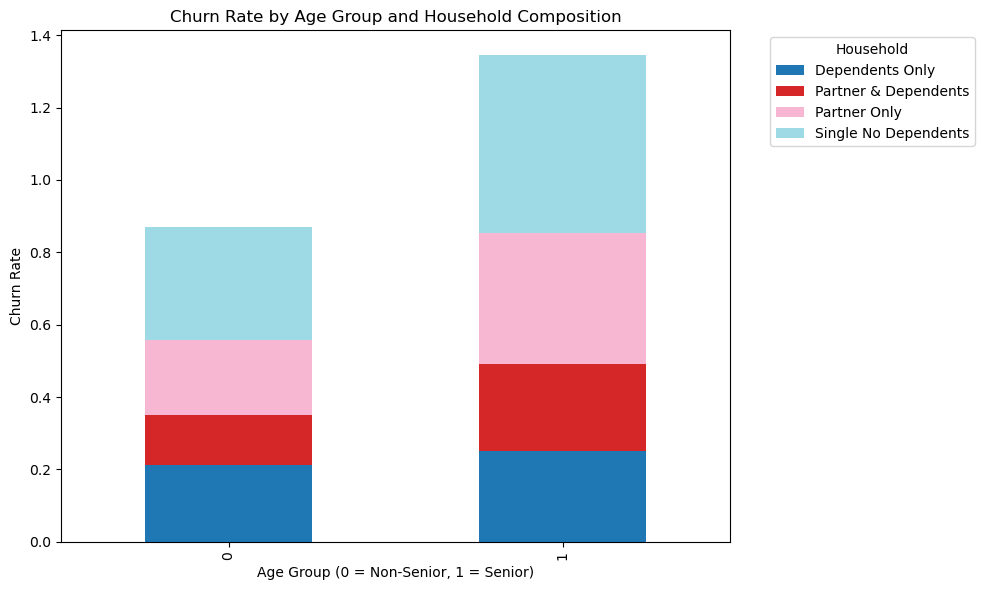

In [370]:
# Visualize churn rate by demographic 

import matplotlib.pyplot as plt

# Define household composition
data["Household"] = data.apply(
    lambda row: (
        "Partner & Dependents" if row["Partner"] == 1 and row["Dependents"] == 1
        else "Partner Only" if row["Partner"] == 1 and row["Dependents"] == 0
        else "Dependents Only" if row["Partner"] == 0 and row["Dependents"] == 1
        else "Single No Dependents"
    ), axis=1
)

# Group by age group & household composition, compute churn rate
churn_by_group = (
    data.groupby(["SeniorCitizen", "Household"])["Churn"]
    .mean()
    .reset_index()
)

# Pivot for stacked bar (Household categories as columns)
churn_pivot = churn_by_group.pivot(
    index="SeniorCitizen", columns="Household", values="Churn"
)

# Plot
churn_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"
)

plt.title("Churn Rate by Age Group and Household Composition")
plt.ylabel("Churn Rate")
plt.xlabel("Age Group (0 = Non-Senior, 1 = Senior)")
plt.legend(title="Household", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

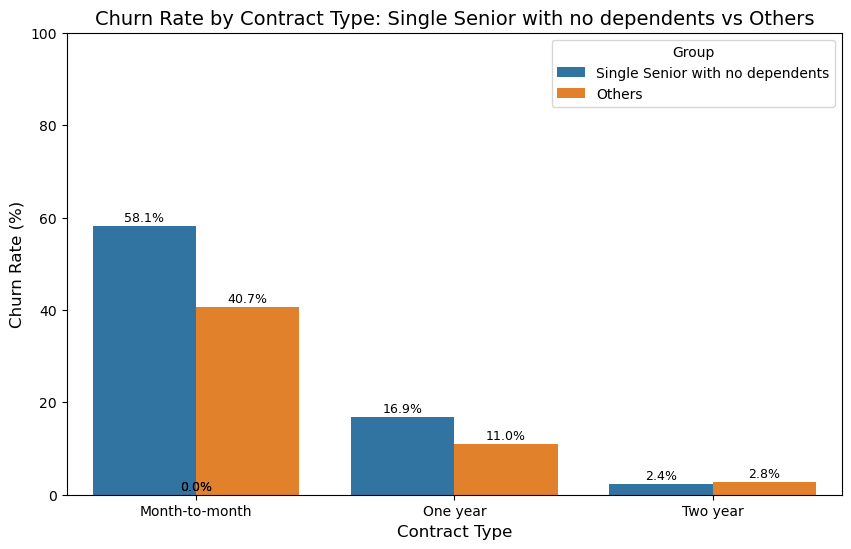

In [411]:
import seaborn as sns

# Churn rate for senior_single_nodep
churn_senior = senior_single_nodep.groupby("Contract")["Churn"].mean().reset_index()
churn_senior["Churn"] *= 100
churn_senior["Group"] = "Single Senior with no dependents"

# Churn rate for others
churn_others = others.groupby("Contract")["Churn"].mean().reset_index()
churn_others["Churn"] *= 100
churn_others["Group"] = "Others"

# Combine
churn_compare = pd.concat([churn_senior, churn_others])

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=churn_compare, x="Contract", y="Churn", hue="Group")

plt.title("Churn Rate by Contract Type: Single Senior with no dependents vs Others", fontsize=14)
plt.xlabel("Contract Type", fontsize=12)
plt.ylabel("Churn Rate (%)", fontsize=12)
plt.ylim(0, 100)

# Annotate bars
for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width()/2, 
        val + 1, 
        f"{val:.1f}%", 
        ha='center', 
        fontsize=9
    )

plt.legend(title="Group")
plt.show()

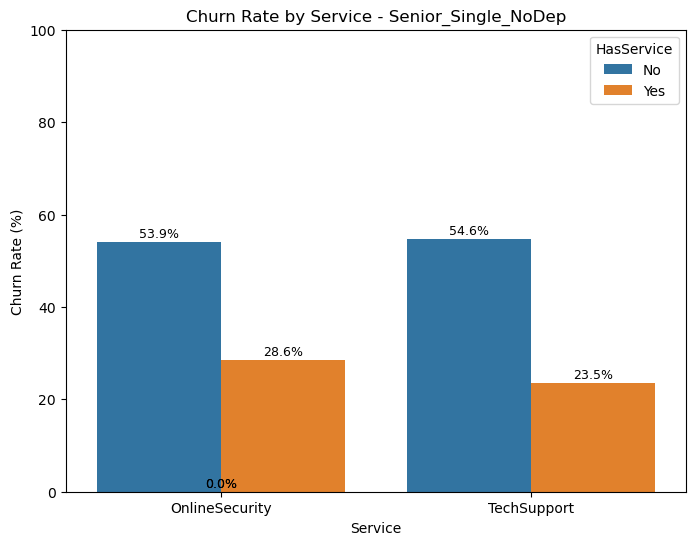

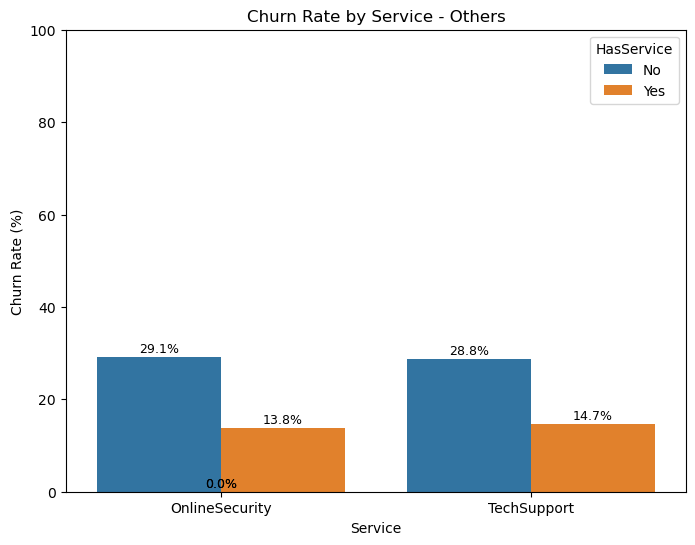

In [423]:
# Copy to preserve original
df = data.copy()

# Collapse "No internet service" (2) into "No" (0) -> new columns
for col in ["OnlineSecurity", "TechSupport"]:
    df[col + "_recoded"] = df[col].replace({2: 0})

# Define groups
senior_single_nodep = df[
    (df['SeniorCitizen'] == 1) &
    (df['Partner'] == 0) &
    (df['Dependents'] == 0)
]
others = df.drop(senior_single_nodep.index)

def get_churn_rates(df, group_name):
    results = []
    for s in ["OnlineSecurity_recoded", "TechSupport_recoded"]:
        temp = df.groupby(s)["Churn"].mean().reset_index()
        temp["HasService"] = temp[s].map({0: "No", 1: "Yes"})  # map 0/1 → No/Yes
        temp["Service"] = s.replace("_recoded", "")
        temp["Group"] = group_name
        temp = temp.drop(columns=[s])  # drop numeric col, keep labels
        results.append(temp)
    return pd.concat(results)

# Get churn rates
churn_senior = get_churn_rates(senior_single_nodep, "Senior_Single_NoDep")
churn_others = get_churn_rates(others, "Others")

# Convert to %
churn_senior["Churn"] *= 100
churn_others["Churn"] *= 100

# ---- Plot for Senior_Single_NoDep ----
plt.figure(figsize=(8,6))
sns.barplot(data=churn_senior, x="Service", y="Churn", hue="HasService")
plt.title("Churn Rate by Service - Senior_Single_NoDep")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, 100)

for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", ha='center', fontsize=9)

plt.show()

# ---- Plot for Others ----
plt.figure(figsize=(8,6))
sns.barplot(data=churn_others, x="Service", y="Churn", hue="HasService")
plt.title("Churn Rate by Service - Others")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, 100)

for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", ha='center', fontsize=9)

plt.show()

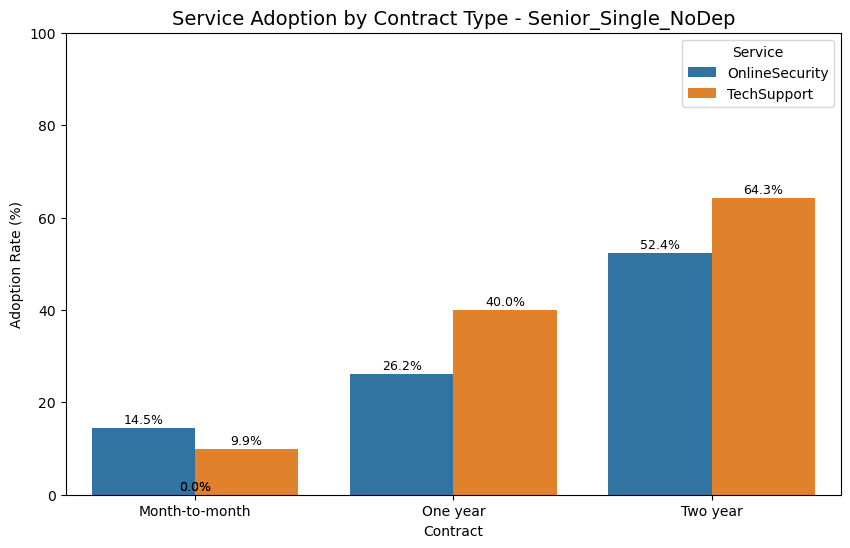

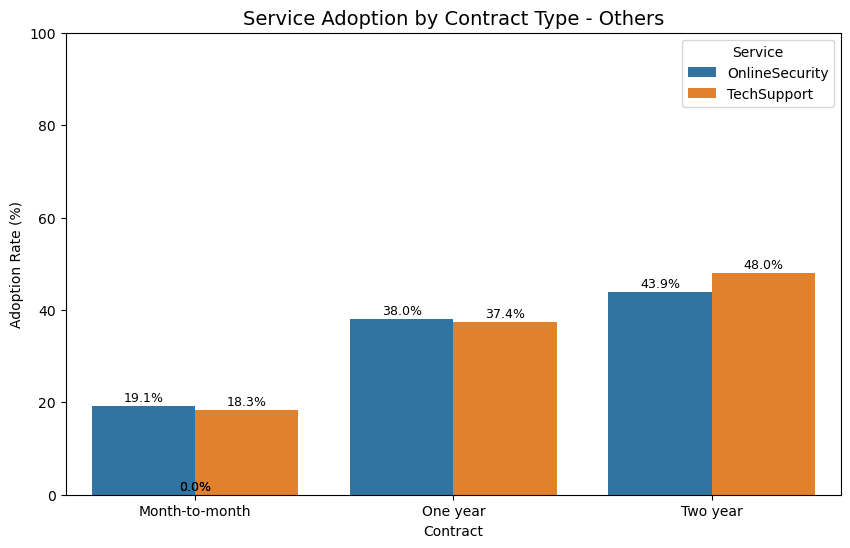

In [427]:
# Service adoption rates by contract type (shows your 19% & 17% observation visually)


def get_adoption_rates(df, group_name):
    temp = df.melt(
        id_vars=["Contract"],
        value_vars=["OnlineSecurity_recoded", "TechSupport_recoded"],
        var_name="Service", value_name="HasService"
    )
    temp["Service"] = temp["Service"].str.replace("_recoded", "")
    temp["HasService"] = temp["HasService"].map({0: "No", 1: "Yes"})
    
    adoption_rate = (
        temp.groupby(["Contract", "Service"])["HasService"]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index(name="AdoptionRate")
    )
    adoption_rate["Group"] = group_name
    return adoption_rate

# Compute for each group
adopt_senior = get_adoption_rates(senior_single_nodep, "Senior_Single_NoDep")
adopt_others = get_adoption_rates(others, "Others")

# ---- Plot for Senior_Single_NoDep ----
plt.figure(figsize=(10,6))
sns.barplot(data=adopt_senior, x="Contract", y="AdoptionRate", hue="Service")

plt.title("Service Adoption by Contract Type - Senior_Single_NoDep", fontsize=14)
plt.ylabel("Adoption Rate (%)")
plt.ylim(0, 100)

for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", 
                   ha="center", fontsize=9)

plt.show()

# ---- Plot for Others ----
plt.figure(figsize=(10,6))
sns.barplot(data=adopt_others, x="Contract", y="AdoptionRate", hue="Service")

plt.title("Service Adoption by Contract Type - Others", fontsize=14)
plt.ylabel("Adoption Rate (%)")
plt.ylim(0, 100)

for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", 
                   ha="center", fontsize=9)

plt.show()

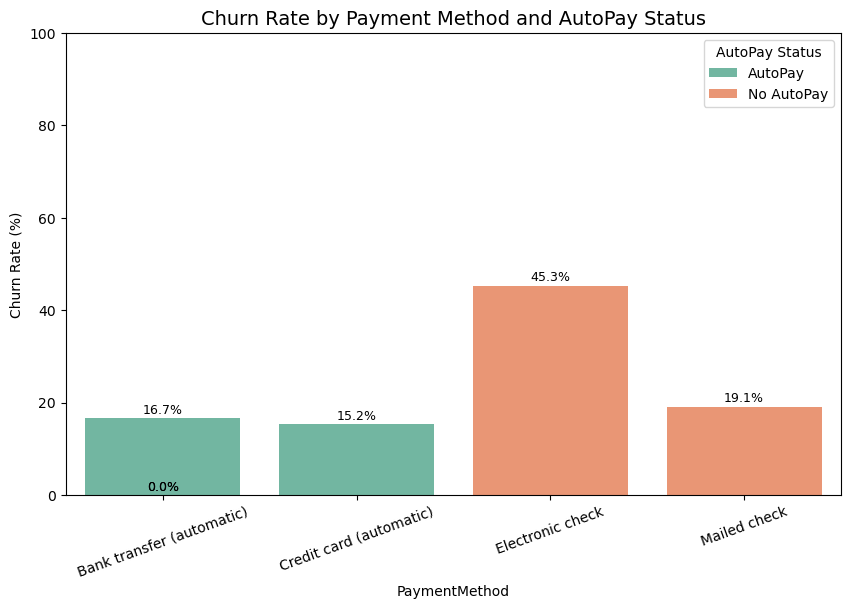

In [431]:
# Ensure AutoPay is cleanly labeled
df["AutoPayStatus"] = df["IsAutoPay"].map({0: "No AutoPay", 1: "AutoPay"})

# Churn grouped by PaymentMethod + AutoPay
pay_autopay_churn = (
    df.groupby(["PaymentMethod", "AutoPayStatus"])["Churn"]
      .mean().reset_index()
)
pay_autopay_churn["Churn"] *= 100

plt.figure(figsize=(10,6))
sns.barplot(
    data=pay_autopay_churn,
    x="PaymentMethod",
    y="Churn",
    hue="AutoPayStatus",
    palette="Set2"
)

plt.title("Churn Rate by Payment Method and AutoPay Status", fontsize=14)
plt.ylabel("Churn Rate (%)")
plt.ylim(0, 100)
plt.xticks(rotation=20)

# Annotate bars with churn %
for bar in plt.gca().patches:
    val = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width()/2, 
        val + 1, 
        f"{val:.1f}%", 
        ha="center", 
        fontsize=9
    )

plt.legend(title="AutoPay Status")
plt.show()